#**1. Import Library**

In [2]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from collections import defaultdict
from collections import Counter
import string
import re

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torch.nn.functional as F
import torch.utils.data as data
from collections import Counter

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#**2. Dataset**

In [4]:
df_X = pd.read_pickle('/content/drive/MyDrive/Training/Train/Train/train_X.pkl')
df_X = pd.DataFrame(df_X, columns=["content"])
df_X.head(10)

,content
0,im feeling abit grouchy with kim
1,i just feel like being selfish and really live...
2,i spent some time at the school yesterday talk...
3,i pray that you feel the presence of god aroun...
4,i do like riding on brooms but there is someth...
5,i feel has such a lovely touch
6,i just need to express my feeling badly ignore...
7,i feel like i ve been there and gained a sense...
8,i come out of that fight feeling whipped and s...
9,i do feel slightly ungrateful about it but i c...


In [5]:
print(df_X.shape)

(12800, 1)


In [6]:
df_y = pd.read_pickle('/content/drive/MyDrive/Training/Train/Train/train_y.pkl')
label_map = {
    0: "Buồn bã",
    1: "Vui vẻ",
    2: "Yêu thích",
    3: "Giận dữ",
    4: "Sợ hãi",
    5: "Bất ngờ"
}
df_y = pd.DataFrame(df_y, columns=["sentiment"])
df_y["label"] = df_y["sentiment"].map(label_map)
print(df_y.head(10))

   sentiment      label
0          3    Giận dữ
1          3    Giận dữ
2          5    Bất ngờ
3          1     Vui vẻ
4          1     Vui vẻ
5          2  Yêu thích
6          3    Giận dữ
7          1     Vui vẻ
8          0    Buồn bã
9          0    Buồn bã


In [7]:
print(df_y.shape)

(12800, 2)


<Axes: xlabel='label', ylabel='count'>

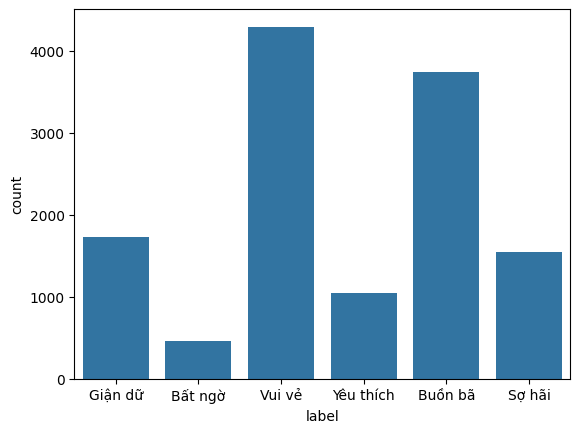

In [8]:
sns.countplot(x = 'label', data = df_y)

# **3. Pre-processing text data**

## **3.1 Remove Punctuation**

In [9]:
def remove_punct(text):
    text  = "".join([char for char in text if char not in string.punctuation])
    text = re.sub('[0-9]+', '', text)
    return text
df_X['Tweet_punct'] = df_X['content'].apply(lambda x: remove_punct(x))
df_X.head(10)

,content,Tweet_punct
0,im feeling abit grouchy with kim,im feeling abit grouchy with kim
1,i just feel like being selfish and really live...,i just feel like being selfish and really live...
2,i spent some time at the school yesterday talk...,i spent some time at the school yesterday talk...
3,i pray that you feel the presence of god aroun...,i pray that you feel the presence of god aroun...
4,i do like riding on brooms but there is someth...,i do like riding on brooms but there is someth...
5,i feel has such a lovely touch,i feel has such a lovely touch
6,i just need to express my feeling badly ignore...,i just need to express my feeling badly ignore...
7,i feel like i ve been there and gained a sense...,i feel like i ve been there and gained a sense...
8,i come out of that fight feeling whipped and s...,i come out of that fight feeling whipped and s...
9,i do feel slightly ungrateful about it but i c...,i do feel slightly ungrateful about it but i c...


## **3.2 Tokenization**

### **3.3.1 Tokenization**

In [10]:
def tokenization(text):
    text = text.lower()
    text = re.split('\W+', text)

    return text

df_X['Tweet_tokenized'] = df_X['Tweet_punct'].apply(lambda x: tokenization(x.lower()))
df_X.head(10)

,content,Tweet_punct,Tweet_tokenized
0,im feeling abit grouchy with kim,im feeling abit grouchy with kim,"[im, feeling, abit, grouchy, with, kim]"
1,i just feel like being selfish and really live...,i just feel like being selfish and really live...,"[i, just, feel, like, being, selfish, and, rea..."
2,i spent some time at the school yesterday talk...,i spent some time at the school yesterday talk...,"[i, spent, some, time, at, the, school, yester..."
3,i pray that you feel the presence of god aroun...,i pray that you feel the presence of god aroun...,"[i, pray, that, you, feel, the, presence, of, ..."
4,i do like riding on brooms but there is someth...,i do like riding on brooms but there is someth...,"[i, do, like, riding, on, brooms, but, there, ..."
5,i feel has such a lovely touch,i feel has such a lovely touch,"[i, feel, has, such, a, lovely, touch]"
6,i just need to express my feeling badly ignore...,i just need to express my feeling badly ignore...,"[i, just, need, to, express, my, feeling, badl..."
7,i feel like i ve been there and gained a sense...,i feel like i ve been there and gained a sense...,"[i, feel, like, i, ve, been, there, and, gaine..."
8,i come out of that fight feeling whipped and s...,i come out of that fight feeling whipped and s...,"[i, come, out, of, that, fight, feeling, whipp..."
9,i do feel slightly ungrateful about it but i c...,i do feel slightly ungrateful about it but i c...,"[i, do, feel, slightly, ungrateful, about, it,..."


### **3.3.2 Removing noise data**

In [11]:
filtered_indices = df_X[df_X["Tweet_tokenized"].apply(len) < 3].index

print(df_X.loc[filtered_indices])

               content      Tweet_punct     Tweet_tokenized
1023         in sweden        in sweden        [in, sweden]
2001         at school        at school        [at, school]
4946   during lectures  during lectures  [during, lectures]
9114       earth crake      earth crake      [earth, crake]
10691   no description   no description   [no, description]
11193          one day          one day          [one, day]
11241      no response      no response      [no, response]


In [12]:
df_X = df_X.drop(index=filtered_indices).reset_index(drop=True)
df_y = df_y.drop(index=filtered_indices).reset_index(drop=True)

print(df_X.shape)
print(df_y.shape)

(12793, 3)
(12793, 2)


## **3.3 Remove Stopwords**

**3.3.1 Download and adding Stopwords**

In [13]:
all_words = [word for tweet in df_X['Tweet_tokenized'] for word in tweet]

word_freq = Counter(all_words)
most_common_words = {word for word, freq in word_freq.most_common(100)}
custom_stopwords = {'yr', 'year', 'woman', 'man', 'girl', 'boy', 'one', 'two', 'sixteen', 'yearold', 'fu', 'weeks', 'week',
                    'treatment', 'associated', 'patients', 'may', 'day', 'case', 'old', 'u', 'n', 'ive', 'ate', 'feel', 'keep', 'a',
                    'brother', 'dad', 'basic', 'im', 'feeling', 'felt', 'look', 'looked', 'havent', 've', 'haven', 'see', 'saw', 'seen',
                    'be', 'was', 'were', 'been', 'get', 'got', 'gotten', 'has', 'have', 'feels', 'has', 'sees', 'eats', 'friends', 'much',
                    'many', 'seem', 'seems', 'seemed', 'really', 'very', 'extremely', 'incredibly', 'too', 'utterly', 'slightly', 'abit',
                    'quite', 'fairly', 'relatively', 'alittle', 'certainly', 'somewhat', 'partly', 'yesterday', 'tommorrow', 'today',
                    'this', 'that', 'come', 'came'}

stopword_set = most_common_words.union(custom_stopwords)

**3.3.2 Remove Stopwords**

In [17]:
def remove_stopwords(text):
    return [word for word in text if word not in stopword_set]

df_X['Tweet_nonstop'] = df_X['Tweet_tokenized'].apply(remove_stopwords)
df_X.head(10)

,content,Tweet_punct,Tweet_tokenized,Tweet_nonstop
0,im feeling abit grouchy with kim,im feeling abit grouchy with kim,"[im, feeling, abit, grouchy, with, kim]","[grouchy, kim]"
1,i just feel like being selfish and really live...,i just feel like being selfish and really live...,"[i, just, feel, like, being, selfish, and, rea...","[selfish, live]"
2,i spent some time at the school yesterday talk...,i spent some time at the school yesterday talk...,"[i, spent, some, time, at, the, school, yester...","[spent, school, talking, folks, snapping, pics..."
3,i pray that you feel the presence of god aroun...,i pray that you feel the presence of god aroun...,"[i, pray, that, you, feel, the, presence, of, ...","[pray, presence, god, around, realize, birth, ..."
4,i do like riding on brooms but there is someth...,i do like riding on brooms but there is someth...,"[i, do, like, riding, on, brooms, but, there, ...","[riding, brooms, sitting, holding, colin, wind..."
5,i feel has such a lovely touch,i feel has such a lovely touch,"[i, feel, has, such, a, lovely, touch]","[such, lovely, touch]"
6,i just need to express my feeling badly ignore...,i just need to express my feeling badly ignore...,"[i, just, need, to, express, my, feeling, badl...","[need, express, badly, ignore, offended]"
7,i feel like i ve been there and gained a sense...,i feel like i ve been there and gained a sense...,"[i, feel, like, i, ve, been, there, and, gaine...","[gained, sense, everyday, paranoia, casual, br..."
8,i come out of that fight feeling whipped and s...,i come out of that fight feeling whipped and s...,"[i, come, out, of, that, fight, feeling, whipp...","[fight, whipped, saddened, hated, put, big, pa..."
9,i do feel slightly ungrateful about it but i c...,i do feel slightly ungrateful about it but i c...,"[i, do, feel, slightly, ungrateful, about, it,...","[ungrateful, only, spend, before, mad]"


##**3.4 Lemmatization**

In [18]:
def simple_lemmatizer(text):
    new_text = []
    for word in text:
        if word.endswith('ing'):
            new_text.append(word[:-3])
        elif word.endswith('ed'):
            new_text.append(word[:-2])
        elif word.endswith('s') and len(word) > 1:
            new_text.append(word[:-1])
        else:
            new_text.append(word)
    return new_text

synonyms_dict = {
    "happy": "glad",
    "sad": "unhappy",
    "angry": "mad",
    "tired": "exhausted",
    "good": "nice",
    "bad": "awful",
    "love": "like",
    "hate": "dislike",
    "big": "large",
    "small": "tiny"
}

def combined_lemmatizer(text):
    text = simple_lemmatizer(text)
    text = [synonyms_dict.get(word, word) for word in text]
    return text

df_X['Tweet_lemmatized'] = df_X['Tweet_nonstop'].apply(combined_lemmatizer)
df_X.head(10)


,content,Tweet_punct,Tweet_tokenized,Tweet_nonstop,Tweet_lemmatized
0,im feeling abit grouchy with kim,im feeling abit grouchy with kim,"[im, feeling, abit, grouchy, with, kim]","[grouchy, kim]","[grouchy, kim]"
1,i just feel like being selfish and really live...,i just feel like being selfish and really live...,"[i, just, feel, like, being, selfish, and, rea...","[selfish, live]","[selfish, live]"
2,i spent some time at the school yesterday talk...,i spent some time at the school yesterday talk...,"[i, spent, some, time, at, the, school, yester...","[spent, school, talking, folks, snapping, pics...","[spent, school, talk, folk, snapp, pic, daught..."
3,i pray that you feel the presence of god aroun...,i pray that you feel the presence of god aroun...,"[i, pray, that, you, feel, the, presence, of, ...","[pray, presence, god, around, realize, birth, ...","[pray, presence, god, around, realize, birth, ..."
4,i do like riding on brooms but there is someth...,i do like riding on brooms but there is someth...,"[i, do, like, riding, on, brooms, but, there, ...","[riding, brooms, sitting, holding, colin, wind...","[rid, broom, sitt, hold, colin, wind, hair, pl..."
5,i feel has such a lovely touch,i feel has such a lovely touch,"[i, feel, has, such, a, lovely, touch]","[such, lovely, touch]","[such, lovely, touch]"
6,i just need to express my feeling badly ignore...,i just need to express my feeling badly ignore...,"[i, just, need, to, express, my, feeling, badl...","[need, express, badly, ignore, offended]","[ne, expres, badly, ignore, offend]"
7,i feel like i ve been there and gained a sense...,i feel like i ve been there and gained a sense...,"[i, feel, like, i, ve, been, there, and, gaine...","[gained, sense, everyday, paranoia, casual, br...","[gain, sense, everyday, paranoia, casual, brut..."
8,i come out of that fight feeling whipped and s...,i come out of that fight feeling whipped and s...,"[i, come, out, of, that, fight, feeling, whipp...","[fight, whipped, saddened, hated, put, big, pa...","[fight, whipp, sadden, hat, put, large, pantie..."
9,i do feel slightly ungrateful about it but i c...,i do feel slightly ungrateful about it but i c...,"[i, do, feel, slightly, ungrateful, about, it,...","[ungrateful, only, spend, before, mad]","[ungrateful, only, spend, before, mad]"


## **3.5 Conversion to index**

In [19]:
all_tokens = [token for tokens in df_X["Tweet_lemmatized"] for token in tokens]
token_counts = Counter(all_tokens)

vocab = {token: idx + 2 for idx, (token, _) in enumerate(token_counts.items())}
vocab["<PAD>"] = 0
vocab["<UNK>"] = 1

def convert_tokens_to_indices(tokens):
    return [vocab.get(token, vocab["<UNK>"]) for token in tokens]

df_X["indexed"] = df_X["Tweet_lemmatized"].apply(convert_tokens_to_indices)
df_X.head(10)

,content,Tweet_punct,Tweet_tokenized,Tweet_nonstop,Tweet_lemmatized,indexed
0,im feeling abit grouchy with kim,im feeling abit grouchy with kim,"[im, feeling, abit, grouchy, with, kim]","[grouchy, kim]","[grouchy, kim]","[2, 3]"
1,i just feel like being selfish and really live...,i just feel like being selfish and really live...,"[i, just, feel, like, being, selfish, and, rea...","[selfish, live]","[selfish, live]","[4, 5]"
2,i spent some time at the school yesterday talk...,i spent some time at the school yesterday talk...,"[i, spent, some, time, at, the, school, yester...","[spent, school, talking, folks, snapping, pics...","[spent, school, talk, folk, snapp, pic, daught...","[6, 7, 8, 9, 10, 11, 12, 13, 14, 7, 15, 16, 17..."
3,i pray that you feel the presence of god aroun...,i pray that you feel the presence of god aroun...,"[i, pray, that, you, feel, the, presence, of, ...","[pray, presence, god, around, realize, birth, ...","[pray, presence, god, around, realize, birth, ...","[24, 25, 26, 27, 28, 29, 26, 30, 31, 32, 33, 34]"
4,i do like riding on brooms but there is someth...,i do like riding on brooms but there is someth...,"[i, do, like, riding, on, brooms, but, there, ...","[riding, brooms, sitting, holding, colin, wind...","[rid, broom, sitt, hold, colin, wind, hair, pl...","[35, 36, 37, 38, 39, 40, 41, 42]"
5,i feel has such a lovely touch,i feel has such a lovely touch,"[i, feel, has, such, a, lovely, touch]","[such, lovely, touch]","[such, lovely, touch]","[43, 44, 45]"
6,i just need to express my feeling badly ignore...,i just need to express my feeling badly ignore...,"[i, just, need, to, express, my, feeling, badl...","[need, express, badly, ignore, offended]","[ne, expres, badly, ignore, offend]","[46, 47, 48, 49, 50]"
7,i feel like i ve been there and gained a sense...,i feel like i ve been there and gained a sense...,"[i, feel, like, i, ve, been, there, and, gaine...","[gained, sense, everyday, paranoia, casual, br...","[gain, sense, everyday, paranoia, casual, brut...","[51, 52, 53, 54, 55, 56]"
8,i come out of that fight feeling whipped and s...,i come out of that fight feeling whipped and s...,"[i, come, out, of, that, fight, feeling, whipp...","[fight, whipped, saddened, hated, put, big, pa...","[fight, whipp, sadden, hat, put, large, pantie...","[57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 6..."
9,i do feel slightly ungrateful about it but i c...,i do feel slightly ungrateful about it but i c...,"[i, do, feel, slightly, ungrateful, about, it,...","[ungrateful, only, spend, before, mad]","[ungrateful, only, spend, before, mad]","[73, 74, 75, 76, 77]"


## **3.6 Padding**

In [20]:
max_len = max(df_X["indexed"].apply(len))
def pad_sequence_tensor(seq, max_len):
    return seq + [vocab["<PAD>"]] * (max_len - len(seq)) if len(seq) < max_len else seq[:max_len]

df_X["padded"] = df_X["indexed"].apply(lambda x: pad_sequence_tensor(x, max_len))
df_X.head(10)

,content,Tweet_punct,Tweet_tokenized,Tweet_nonstop,Tweet_lemmatized,indexed,padded
0,im feeling abit grouchy with kim,im feeling abit grouchy with kim,"[im, feeling, abit, grouchy, with, kim]","[grouchy, kim]","[grouchy, kim]","[2, 3]","[2, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,i just feel like being selfish and really live...,i just feel like being selfish and really live...,"[i, just, feel, like, being, selfish, and, rea...","[selfish, live]","[selfish, live]","[4, 5]","[4, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,i spent some time at the school yesterday talk...,i spent some time at the school yesterday talk...,"[i, spent, some, time, at, the, school, yester...","[spent, school, talking, folks, snapping, pics...","[spent, school, talk, folk, snapp, pic, daught...","[6, 7, 8, 9, 10, 11, 12, 13, 14, 7, 15, 16, 17...","[6, 7, 8, 9, 10, 11, 12, 13, 14, 7, 15, 16, 17..."
3,i pray that you feel the presence of god aroun...,i pray that you feel the presence of god aroun...,"[i, pray, that, you, feel, the, presence, of, ...","[pray, presence, god, around, realize, birth, ...","[pray, presence, god, around, realize, birth, ...","[24, 25, 26, 27, 28, 29, 26, 30, 31, 32, 33, 34]","[24, 25, 26, 27, 28, 29, 26, 30, 31, 32, 33, 3..."
4,i do like riding on brooms but there is someth...,i do like riding on brooms but there is someth...,"[i, do, like, riding, on, brooms, but, there, ...","[riding, brooms, sitting, holding, colin, wind...","[rid, broom, sitt, hold, colin, wind, hair, pl...","[35, 36, 37, 38, 39, 40, 41, 42]","[35, 36, 37, 38, 39, 40, 41, 42, 0, 0, 0, 0, 0..."
5,i feel has such a lovely touch,i feel has such a lovely touch,"[i, feel, has, such, a, lovely, touch]","[such, lovely, touch]","[such, lovely, touch]","[43, 44, 45]","[43, 44, 45, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
6,i just need to express my feeling badly ignore...,i just need to express my feeling badly ignore...,"[i, just, need, to, express, my, feeling, badl...","[need, express, badly, ignore, offended]","[ne, expres, badly, ignore, offend]","[46, 47, 48, 49, 50]","[46, 47, 48, 49, 50, 0, 0, 0, 0, 0, 0, 0, 0, 0..."
7,i feel like i ve been there and gained a sense...,i feel like i ve been there and gained a sense...,"[i, feel, like, i, ve, been, there, and, gaine...","[gained, sense, everyday, paranoia, casual, br...","[gain, sense, everyday, paranoia, casual, brut...","[51, 52, 53, 54, 55, 56]","[51, 52, 53, 54, 55, 56, 0, 0, 0, 0, 0, 0, 0, ..."
8,i come out of that fight feeling whipped and s...,i come out of that fight feeling whipped and s...,"[i, come, out, of, that, fight, feeling, whipp...","[fight, whipped, saddened, hated, put, big, pa...","[fight, whipp, sadden, hat, put, large, pantie...","[57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 6...","[57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 6..."
9,i do feel slightly ungrateful about it but i c...,i do feel slightly ungrateful about it but i c...,"[i, do, feel, slightly, ungrateful, about, it,...","[ungrateful, only, spend, before, mad]","[ungrateful, only, spend, before, mad]","[73, 74, 75, 76, 77]","[73, 74, 75, 76, 77, 0, 0, 0, 0, 0, 0, 0, 0, 0..."


##**3.7 After Pre-processing**

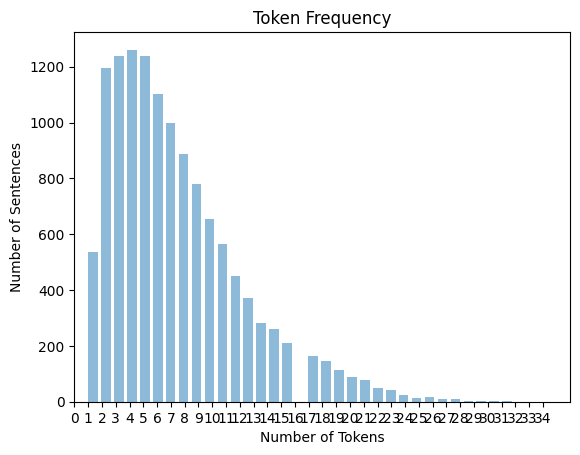

In [21]:
token_lengths = [len(t) for t in df_X['Tweet_lemmatized']]
plt.hist(token_lengths,bins=33,width = 0.7, fc="green",alpha=0.5)
plt.xlabel('Number of Tokens')
plt.ylabel('Number of Sentences')
plt.title('Token Frequency')
x_Values = [i for i in range(35)]
plt.xticks(x_Values)
plt.xlim(0,36)
plt.rcParams["figure.figsize"] = (10,5)
plt.show()

# **4. Training**

## **4.4 Hydrid (LSTMC x FNN)**

In [22]:
X_tensor = torch.tensor(df_X["padded"].tolist(), dtype=torch.long)
y_tensor = torch.tensor(df_y["sentiment"].values, dtype=torch.long)

X_train, X_test, y_train, y_test = train_test_split(X_tensor, y_tensor, test_size=0.2, random_state=42)

batch_size = 4
train_dataset = data.TensorDataset(X_train, y_train)
test_dataset = data.TensorDataset(X_test, y_test)
train_loader = data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [23]:
class HybridModel(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, output_size, num_layers=2, dropout=0.3):
        super(HybridModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        self.lstm = nn.LSTM(embed_dim, hidden_dim, num_layers=num_layers, batch_first=True, dropout=dropout)
        self.fc1 = nn.Linear(hidden_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        x = self.embedding(x)
        lstm_out, _ = self.lstm(x)
        x = self.fc1(lstm_out[:, -1, :])
        x = torch.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [24]:
def train(model, train_loader, test_loader, criterion, optimizer, epochs=10):
    model.to(device)
    train_losses, test_losses, accuracies = [], [], []

    for e in range(epochs):
        running_loss = 0
        model.train()

        for sentences, labels in train_loader:
            sentences, labels = sentences.to(device), labels.to(device)
            optimizer.zero_grad()
            pred = model(sentences)
            loss = criterion(pred, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        model.eval()
        test_loss = 0
        correct = 0
        total = 0

        with torch.no_grad():
            for sentences, labels in test_loader:
                sentences, labels = sentences.to(device), labels.to(device)
                log_ps = model(sentences)
                test_loss += criterion(log_ps, labels).item()

                top_class = torch.argmax(log_ps, dim=1)
                correct += (top_class == labels).sum().item()
                total += labels.size(0)

        train_losses.append(running_loss / len(train_loader))
        test_losses.append(test_loss / len(test_loader))
        accuracy = correct / total * 100
        accuracies.append(accuracy)

        print(f"Epoch: {e+1}/{epochs}.. "
              f"Training Loss: {running_loss / len(train_loader):.3f}.. "
              f"Test Loss: {test_loss / len(test_loader):.3f}.. "
              f"Test Accuracy: {accuracy:.3f}%")

    plt.figure(figsize=(12, 4))
    plt.plot(train_losses, label='Training Loss', color='blue')
    plt.plot(test_losses, label='Testing Loss', color='red')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training & Testing Loss')
    plt.legend()
    plt.grid()
    plt.show()

    plt.figure(figsize=(12, 4))
    plt.plot(accuracies, label='Test Accuracy', color='green')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.title('Test Accuracy over Epochs')
    plt.legend()
    plt.grid()
    plt.show()

Epoch: 1/10.. Training Loss: 1.592.. Test Loss: 1.575.. Test Accuracy: 33.959%
Epoch: 2/10.. Training Loss: 1.584.. Test Loss: 1.575.. Test Accuracy: 33.959%
Epoch: 3/10.. Training Loss: 1.579.. Test Loss: 1.574.. Test Accuracy: 33.959%
Epoch: 4/10.. Training Loss: 1.510.. Test Loss: 1.327.. Test Accuracy: 40.524%
Epoch: 5/10.. Training Loss: 1.204.. Test Loss: 1.086.. Test Accuracy: 45.721%
Epoch: 6/10.. Training Loss: 0.909.. Test Loss: 0.755.. Test Accuracy: 73.701%
Epoch: 7/10.. Training Loss: 0.494.. Test Loss: 0.577.. Test Accuracy: 83.275%
Epoch: 8/10.. Training Loss: 0.306.. Test Loss: 0.517.. Test Accuracy: 84.682%
Epoch: 9/10.. Training Loss: 0.220.. Test Loss: 0.535.. Test Accuracy: 85.502%
Epoch: 10/10.. Training Loss: 0.162.. Test Loss: 0.549.. Test Accuracy: 85.971%


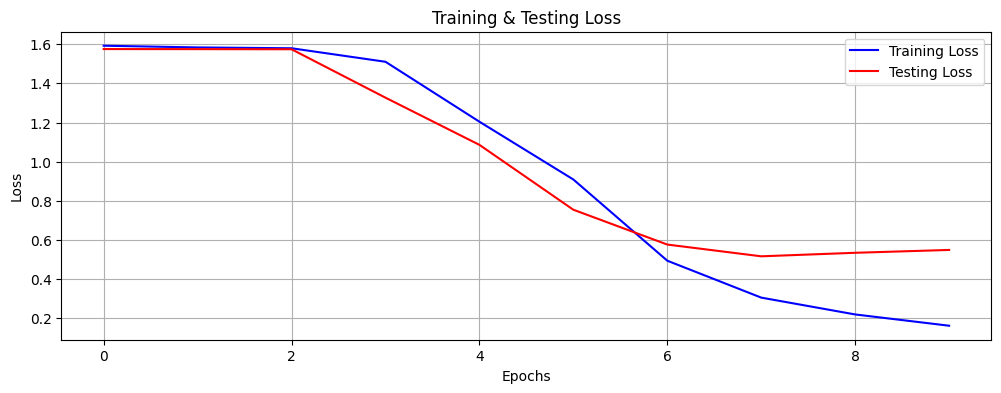

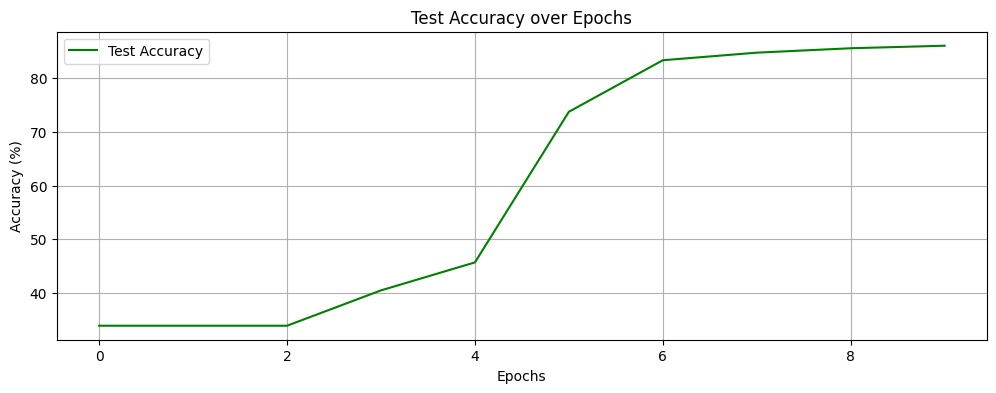

In [26]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

vocab_size = df_X["padded"].apply(max).max() + 1
embed_dim = 100
hidden_dim = 128
output_size = df_y["sentiment"].nunique()

model = HybridModel(vocab_size, embed_dim, hidden_dim, output_size).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.002)
train(model, train_loader, test_loader, criterion, optimizer, epochs=10)
torch.save(model.state_dict(), "hybrid_model.pth")

#  **5. Prediction**

## **5.1 Pre-Training**

In [28]:
df_test = pd.read_pickle('/content/drive/MyDrive/Training/Train/Test/private_X.pkl')
df_test = pd.DataFrame(df_test, columns=["content"])
df_test.head(10)

,content
0,i feel tortured by this thought but it feels s...
1,i have a few favourites of my own but the choi...
2,i friends helping them to dress up and practis...
3,i feel more shitty and emotional and helpless
4,i can look back likely years from now realize ...
5,i came close to just packing up and heading ho...
6,i do feel a little needy
7,i haven t been able to shake this akward and u...
8,i feel hesitant around it
9,i just didnt feel inspired


In [30]:
df_test['Tweet_punct'] = df_test['content'].apply(lambda x: remove_punct(x))
df_test['Tweet_tokenized'] = df_test['Tweet_punct'].apply(lambda x: tokenization(x.lower()))
df_test['Tweet_nonstop'] = df_test['Tweet_tokenized'].apply(lambda x: remove_stopwords(x))
df_test['Tweet_lemmatized'] = df_test['Tweet_nonstop'].apply(lambda x: combined_lemmatizer(x)) # Changed 'lemmatizer' to 'combined_lemmatizer'
df_test["indexed"] = df_test["Tweet_lemmatized"].apply(convert_tokens_to_indices)
df_test["padded"] = df_test["indexed"].apply(lambda x: pad_sequence_tensor(x, max_len))
df_test.head(10)

,content,Tweet_punct,Tweet_tokenized,Tweet_nonstop,Tweet_lemmatized,indexed,padded
0,i feel tortured by this thought but it feels s...,i feel tortured by this thought but it feels s...,"[i, feel, tortured, by, this, thought, but, it...","[tortured, thought, true]","[tortur, thought, true]","[753, 489, 880]","[753, 489, 880, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,i have a few favourites of my own but the choi...,i have a few favourites of my own but the choi...,"[i, have, a, few, favourites, of, my, own, but...","[few, favourites, own, choice, book, dvd, us, ...","[few, favourite, own, choice, book, dvd, u, uk...","[344, 5069, 140, 2952, 261, 2849, 465, 2674, 4...","[344, 5069, 140, 2952, 261, 2849, 465, 2674, 4..."
2,i friends helping them to dress up and practis...,i friends helping them to dress up and practis...,"[i, friends, helping, them, to, dress, up, and...","[helping, dress, practise, their, thai, introd...","[help, dres, practise, their, thai, introducti...","[352, 2317, 4420, 1095, 2374, 6255, 523, 136, ...","[352, 2317, 4420, 1095, 2374, 6255, 523, 136, ..."
3,i feel more shitty and emotional and helpless,i feel more shitty and emotional and helpless,"[i, feel, more, shitty, and, emotional, and, h...","[shitty, emotional, helpless]","[shitty, emotional, helples]","[167, 141, 906]","[167, 141, 906, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,i can look back likely years from now realize ...,i can look back likely years from now realize ...,"[i, can, look, back, likely, years, from, now,...","[likely, years, realize, impact, several, less...","[likely, year, realize, impact, several, lesso...","[3941, 345, 28, 3307, 2129, 2631, 268, 144, 82...","[3941, 345, 28, 3307, 2129, 2631, 268, 144, 82..."
5,i came close to just packing up and heading ho...,i came close to just packing up and heading ho...,"[i, came, close, to, just, packing, up, and, h...","[close, packing, heading, home, then, wondered...","[close, pack, head, home, then, wonder, home, ...","[2791, 1127, 297, 148, 305, 359, 148, 315, 192]","[2791, 1127, 297, 148, 305, 359, 148, 315, 192..."
6,i do feel a little needy,i do feel a little needy,"[i, do, feel, a, little, needy]",[needy],[needy],[209],"[209, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0..."
7,i haven t been able to shake this akward and u...,i haven t been able to shake this akward and u...,"[i, haven, t, been, able, to, shake, this, akw...","[able, shake, akward, unusual, irritable, spac...","[able, shake, akward, unusual, irritable, spac...","[868, 3066, 1, 4701, 749, 2590, 1, 324, 1341]","[868, 3066, 1, 4701, 749, 2590, 1, 324, 1341, ..."
8,i feel hesitant around it,i feel hesitant around it,"[i, feel, hesitant, around, it]","[hesitant, around]","[hesitant, around]","[672, 27]","[672, 27, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
9,i just didnt feel inspired,i just didnt feel inspired,"[i, just, didnt, feel, inspired]","[didnt, inspired]","[didnt, inspir]","[137, 786]","[137, 786, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."


In [ ]:
print(df_test.shape)

(3284, 7)


## **5.2  Prediction**

### **5.2.2 Model Hydrid (LSTMC x FNN)**


In [31]:
X_test_tensor = torch.tensor(df_test["padded"].tolist(), dtype=torch.long)

batch_size = 4

test_loader = torch.utils.data.DataLoader(
    X_test_tensor, batch_size=batch_size, shuffle=False, drop_last=False
)

print(f"Total test samples: {len(df_test)}")
print(f"Total batches: {len(test_loader)}")


Total test samples: 3284
Total batches: 821


In [33]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = HybridModel(vocab_size, embed_dim, hidden_dim, output_size).to(device)
model.load_state_dict(torch.load("hybrid_model.pth"))
model.eval()

predictions = []

with torch.no_grad():
    for batch in test_loader:
        batch = batch.to(device)
        outputs = model(batch)
        preds = torch.argmax(outputs, dim=1)
        predictions.extend(preds.cpu().numpy())

print(f"Total predictions: {len(predictions)}")
print(predictions[:10])

<ipython-input-33-94557b4c08f6>:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("hybrid_model.pth"))


Total predictions: 3284
[3, 1, 0, 0, 1, 0, 0, 3, 4, 1]


In [ ]:
predictions_list_LSTMCxFNN = predictions
import pickle
with open("submission.pkl", "wb") as f:
    pickle.dump(predictions_list_LSTMCxFNN, f)

In [ ]:
import zipfile

with zipfile.ZipFile("submission.zip", "w") as zipf:
    zipf.write("submission.pkl")

In [ ]:
from google.colab import files
files.download("submission.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>